In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
from collections import defaultdict


In [191]:
%config Completer.use_jedi = False

In [3]:
# refractory period 8s, 16 steps.

In [4]:
CHANNEL_HL = 26 # BL

In [5]:
class ChannelEnvironment:
    def __init__(self, food_coords=[0], enable_food_time=5, disable_food_time=100, refractory_period = 16):
        self.refractory_period = refractory_period
        
        self.food_w = np.pi/CHANNEL_HL/2. # half-width of the food., 2xfood_w = BL, same as step size.
        self.food = np.array(food_coords)
        self.food_enabled = np.array([False]*len(food_coords)) # all food locations disabled
        
        self.schedule = defaultdict(dict)
        #self.schedule = {5: dict(0=True), 20: dict(0=False)} # default schedule
        self.schedule[enable_food_time]={0:True}
        self.schedule[disable_food_time]={0:False}
        
        self.fly_on_food = None
        self.last_t = 0
        
        self.food_log = {"t":[], 0:[]}
        
    def env_state_update(self, t): # when the food is active
        self.last_t = t
        if t in self.schedule.keys():
            actions = self.schedule[t]
            for foodid, state in actions.items():
                self.set_enabled_food(foodid, state)
            del self.schedule[t]
            
        for ifood in range(len(self.food)):
            self.food_log["t"].append(self.last_t)
            self.food_log[ifood].append(self.food_enabled[ifood])
            
    def update(self, fly_coord, t):
        self.env_state_update(t)
        food_locs, food_indices = self.get_enabled_food_locations()
        for food_index,food_loc in zip(food_indices, food_locs):
             print("update:", t, food_loc, fly_coord, 
                   "fly-food:",np.abs(fly_coord - food_loc), 
                   "mod2pi:", np.abs(fly_coord - food_loc)%(2* np.pi))
             if np.abs(fly_coord - food_loc)%(2* np.pi) <= self.food_w:
                self.fly_on_food=food_index
                return self.fly_on_food
        self.fly_on_food=None
        return self.fly_on_food
        
    def get_enabled_food_locations(self):
        return self.food[self.food_enabled], self.food_enabled.nonzero()[0] #locations, indices
    
    def set_enabled_food(self, food_i, enabled_value):
        self.food_enabled[food_i] = enabled_value
        print(f"t={self.last_t}: Food #{food_i} [{self.food[food_i]}] := {enabled_value}")
        
    def enable_food(self, food_i=0):
        self.set_enabled_food(food_i, True)
        
    def disable_food(self, food_i=0, refractory=False):
        self.set_enabled_food(food_i, False)
        if refractory:
            for tbetween in range(self.last_t, self.last_t+self.refractory_period+1):
                if tbetween in self.schedule and not self.schedule[tbetween].get(food_i,True):
                    return                
            self.schedule[self.last_t+self.refractory_period][food_i]= True
    
    def print_current_state(self):
        print(np.vstack([self.food, self.food_enabled]))
    
    

In [6]:
foods = np.array([1,2,3])
enabled = np.array([True,False, True])
foods[enabled]

array([1, 3])

In [7]:
print(np.vstack([foods, enabled]))

[[1 2 3]
 [1 0 1]]


In [8]:
indices = enabled.nonzero()[0]

In [9]:
phi_step = np.pi / CHANNEL_HL # 26 body length opposite side - figS3A
# 1 step 0.5 s, 1 BL

class MyFly:
    def __init__(self):
        self.eating_time = 10
        
        self.environment = ChannelEnvironment()
        self.t = 0
        
        # mind
        self.state='walking' # or eating
        self.mode='GS' # or LS
        self.direction=1 # or -1
        self.last_state=None
        self.integrator_x=0
        self.integrator_y=0
        
        self.current_run = 0
        
        # env
        self.coord_x=0
        self.coord_y=0
        self.coord_phi= - 8* phi_step
        
        # log
        self.phi_log=[self.coord_phi] # to save history
        self.t_log=[0]
        self.eat_log=[False]
        self.direction_log=[self.direction]
        
    def log(self, eating=False):
        self.t_log.append(self.t)
        self.phi_log.append(self.coord_phi)
        self.eat_log.append(eating)
        self.direction_log.append(self.direction)

    def make_step(self, direction):
        self.t+=1
        d_angle = phi_step*direction
        self.coord_phi += d_angle
        self.coord_x = np.cos(self.coord_phi)
        self.coord_y = np.sin(self.coord_phi)
        dx = np.cos(d_angle)
        dy = np.sin(d_angle)
        self.integrator_x+=dx
        self.integrator_y+=dy
        self.current_run += np.sqrt(dx**2+dy**2)
        
        self.log()
        
        am_on_food = self.environment.update(self.coord_phi, self.t)
        if am_on_food is not None:
            self.on_food(am_on_food)
    
    def plot_angle_history(self, ax=None):
        if ax is None:
            ax=plt.gca()
        ax.plot(self.t_log, self.phi_log, '.-')

    def plot_trajectory(self, ax=None):
        if ax is None:
            ax=plt.gca()
        
        angles = np.array(self.phi_log)
        xx = np.cos(angles)
        yy = np.sin(angles)
        ax.plot(xx, yy)
        ax.axis('equal')
    
    def on_food(self, food_index):
        print(self.t, " - fly on food!")
        self.mode = 'LS' # enter the local search mode

        # remember the eating state
        self.last_state = 'eating'

        # disable food source for refractory period
        self.environment.disable_food(food_index, refractory=True)
        
        # stay on food location for a while
        self.eat()
        
        self.zero_integrator()
        self.choose_run_length()
        
        
    def eat(self):
        # do nothing for self.eating time (only update the environment based on current time)
        for t in range(self.eating_time):
            self.t+=1
            # update log at every step
            self.log(eating=True)
#             self.t_log.append(self.t)
#             self.phi_log.append(self.coord_phi)
            # update environment
            print('fly eating', self.t)
            self.environment.update(self.coord_phi, self.t)

    def choose_run_length(self):
        # if just was on food
        if self.last_state=='eating':
            self.run_length = np.random.normal(RL_mean, RL_std) + self.current_run
        elif self.last_state == 'reversal':
            self.run_length = np.abs(self.current_run + np.random.normal(dRL_mean, dRL_std))
        print(f"Prev: {self.last_state}, current run: {self.current_run}, RL:{self.run_length}" )
            
    def zero_integrator(self):
        self.integrator_x = 0
        self.integrator_y = 0
        self.current_run = 0
        
    def start_walking(self, Tlim = 500):
        while self.mode == "GS":
            self.make_step(self.direction)
        if self.mode == 'LS':
            while self.t < Tlim:
                print(f"{self.t} | run: {self.current_run}")
                self.make_step(self.direction)
                if self.current_run >=self.run_length:
                    self.reversal()
    def reversal(self):
        self.direction *= -1        
        self.choose_run_length()
        self.zero_integrator()
        self.last_state = 'reversal'
        
    def get_df(self):
        df = pd.DataFrame(dict(t=fly.t_log, angle=fly.phi_log, 
                                 eating=fly.eat_log, direction=fly.direction_log))
        run_num = df.direction.diff().abs()/2
        df["run_num"] = run_num.cumsum()
        df.loc[0, "run_num"] = 0
        df.run_num = df.run_num - df[df.eating].iloc[-1].run_num - 1
        return df
    

In [10]:
RL_mean = 4.125
RL_std = 2.625
dRL_mean = 0.03125
dRL_std = 1.875
np.random.normal(RL_mean, RL_std)

5.316271495741631

In [11]:
f = MyFly()

In [12]:
for i in range(3):
    f.make_step(1)
for i in range(30):
    f.make_step(-1)

t=5: Food #0 [0] := True
update: 5 0 -0.8458134067357135 fly-food: 0.8458134067357135 mod2pi: 0.8458134067357135
update: 6 0 -0.966643893412244 fly-food: 0.966643893412244 mod2pi: 0.966643893412244
update: 7 0 -1.0874743800887745 fly-food: 1.0874743800887745 mod2pi: 1.0874743800887745
update: 8 0 -1.208304866765305 fly-food: 1.208304866765305 mod2pi: 1.208304866765305
update: 9 0 -1.3291353534418353 fly-food: 1.3291353534418353 mod2pi: 1.3291353534418353
update: 10 0 -1.4499658401183657 fly-food: 1.4499658401183657 mod2pi: 1.4499658401183657
update: 11 0 -1.5707963267948961 fly-food: 1.5707963267948961 mod2pi: 1.5707963267948961
update: 12 0 -1.6916268134714265 fly-food: 1.6916268134714265 mod2pi: 1.6916268134714265
update: 13 0 -1.812457300147957 fly-food: 1.812457300147957 mod2pi: 1.812457300147957
update: 14 0 -1.9332877868244873 fly-food: 1.9332877868244873 mod2pi: 1.9332877868244873
update: 15 0 -2.0541182735010177 fly-food: 2.0541182735010177 mod2pi: 2.0541182735010177
update: 16

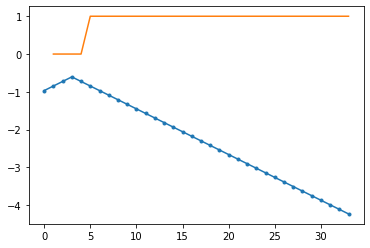

In [13]:
fig, ax = plt.subplots() 
f.plot_angle_history(ax)
plt.plot(f.environment.food_log["t"], f.environment.food_log[0])

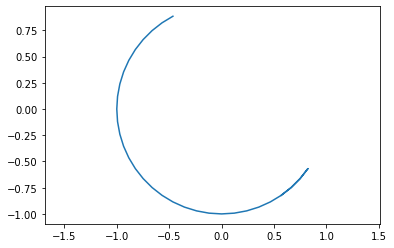

In [14]:
f.plot_trajectory()

In [15]:
fly = MyFly()

In [16]:
fly.start_walking(Tlim=200)

t=5: Food #0 [0] := True
update: 5 0 -0.36249146002959143 fly-food: 0.36249146002959143 mod2pi: 0.36249146002959143
update: 6 0 -0.24166097335306091 fly-food: 0.24166097335306091 mod2pi: 0.24166097335306091
update: 7 0 -0.12083048667653042 fly-food: 0.12083048667653042 mod2pi: 0.12083048667653042
update: 8 0 8.326672684688674e-17 fly-food: 8.326672684688674e-17 mod2pi: 8.326672684688674e-17
8  - fly on food!
t=8: Food #0 [0] := False
fly eating 9
fly eating 10
fly eating 11
fly eating 12
fly eating 13
fly eating 14
fly eating 15
fly eating 16
fly eating 17
fly eating 18
Prev: eating, current run: 0, RL:-0.3040445790567299
18 | run: 0
Prev: eating, current run: 1.0, RL:-2.091656171980599
19 | run: 0
Prev: reversal, current run: 1.0, RL:2.961166451376528
20 | run: 0
21 | run: 1.0
22 | run: 2.0
Prev: reversal, current run: 3.0, RL:5.387854472160557
23 | run: 0
t=24: Food #0 [0] := True
update: 24 0 0.24166097335306108 fly-food: 0.24166097335306108 mod2pi: 0.24166097335306108
24 | run: 1.0

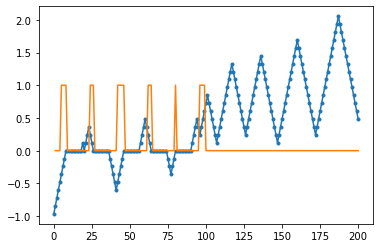

In [17]:
fly.plot_angle_history()
plt.plot(fly.environment.food_log["t"], fly.environment.food_log[0])

In [18]:
df = fly.get_df()

In [19]:
run_num = df.direction.diff().abs()/2

In [20]:
df["run_num"] = run_num.cumsum()

In [21]:
df.loc[0, "run_num"] = 0

In [22]:
df[df.eating].iloc[-1]

t                     90
angle        8.32667e-17
eating              True
direction              1
run_num                6
Name: 90, dtype: object

In [23]:
#df.loc[0, "run_num"] = 0
df.run_num = df.run_num - df[df.eating].iloc[-1].run_num - 1

In [24]:
for rn in [-1,0,1]:
    print(df[df.run_num ==rn].eating.unique())

[False  True]
[False]
[False]


In [25]:
df.run_num.unique()

array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,
        6.,  7.,  8.,  9., 10.])

In [26]:
run_info = df.groupby("run_num").aggregate({'angle':['first', 'last']})

In [27]:
run_info.columns = ["_".join(x) for x in run_info.columns.ravel()]


In [28]:
run_info

,angle_first,angle_last
run_num,,
-7.0,-9.666439e-01,1.208305e-01
-6.0,8.326673e-17,8.326673e-17
-5.0,1.208305e-01,3.624915e-01
-4.0,2.416610e-01,-6.041524e-01
-3.0,-4.833219e-01,4.833219e-01
-2.0,3.624915e-01,-3.624915e-01
-1.0,-2.416610e-01,4.833219e-01
0.0,3.624915e-01,2.416610e-01
1.0,3.624915e-01,8.458134e-01


In [29]:
run_info["run_midpoint"] = (run_info.angle_last + run_info.angle_first)/2

In [30]:
run_info.run_midpoint

run_num
-7.0    -4.229067e-01
-6.0     8.326673e-17
-5.0     2.416610e-01
-4.0    -1.812457e-01
-3.0     8.326673e-17
-2.0     8.326673e-17
-1.0     1.208305e-01
 0.0     3.020762e-01
 1.0     6.041524e-01
 2.0     4.229067e-01
 3.0     7.853982e-01
 4.0     7.249829e-01
 5.0     9.062287e-01
 6.0     7.249829e-01
 7.0     9.666439e-01
 8.0     9.062287e-01
 9.0     1.208305e+00
 10.0    1.208305e+00
Name: run_midpoint, dtype: float64

In [42]:
df = pd.read_csv("fr_simulations.csv")

In [43]:
df.head()

,t,angle,eating,direction,run_num,flyid
0,0,-0.966644,False,1,-32.0,0
1,1,-0.845813,False,1,-32.0,0
2,2,-0.724983,False,1,-32.0,0
3,3,-0.604152,False,1,-32.0,0
4,4,-0.483322,False,1,-32.0,0


In [34]:
run_info = df.groupby(["flyid","run_num"]).aggregate({'angle':['first', 'last']}).reset_index()
run_info.columns = ["_".join(x) for x in run_info.columns.ravel()]


In [35]:
run_info['run_midpoint']=(run_info.angle_last + run_info.angle_first)/2

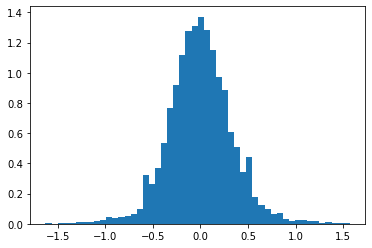

In [37]:
h=plt.hist(run_info[run_info["run_num_"]<0].run_midpoint,density=True, bins=50)

In [39]:
abins = np.linspace(-np.pi, np.pi,100)

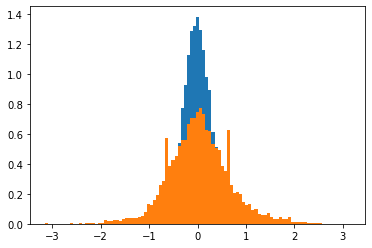

In [40]:
h=plt.hist(run_info[run_info["run_num_"]<0].run_midpoint,density=True, bins=abins)
h=plt.hist(run_info[run_info["run_num_"]>=0].run_midpoint,density=True, bins=abins)

In [41]:
df.columns

Index(['t', 'angle', 'eating', 'direction', 'run_num', 'flyid'], dtype='object')

In [162]:

df = pd.read_csv("data/pheromone_simulations_4.csv")

In [163]:
df.head()

,t,angle,eating,direction,smelling,run_num,flyid,last_food_coord,last_food_index
0,0,-0.966644,False,1,False,-28.0,0,0.0,0
1,1,-0.845813,False,1,False,-28.0,0,0.0,0
2,2,-0.724983,False,1,False,-28.0,0,0.0,0
3,3,-0.604152,False,1,False,-28.0,0,0.0,0
4,4,-0.483322,False,1,False,-28.0,0,0.0,0


In [164]:
df.last_food_index.unique()

array([0, 1, 2])

In [165]:
df.last_food_coord.unique()

array([ 0.        ,  0.60415243, -0.60415243])

In [166]:
# df.flyid.unique()

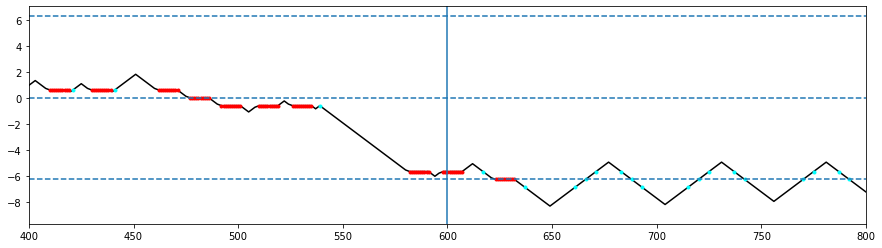

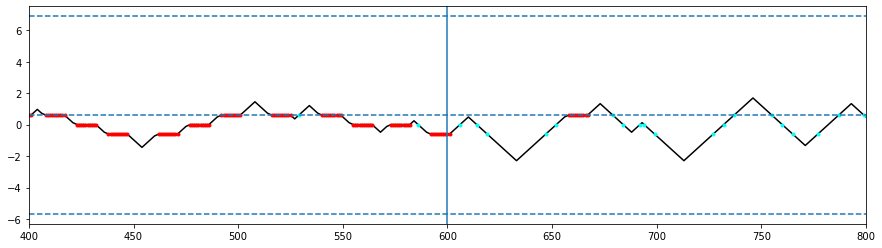

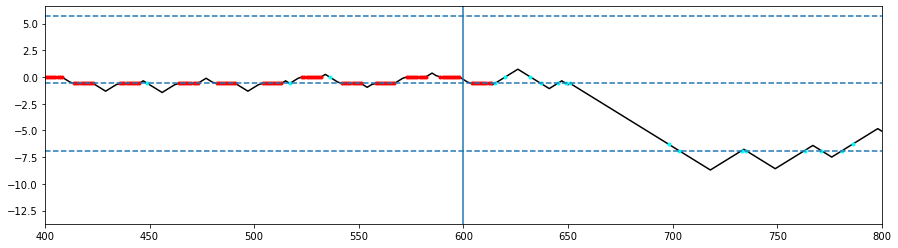

In [167]:
i=0
for flyid, data in df.groupby("flyid"):
    if i>2: 
        break    
    plt.figure(figsize=(15,4))
    plt.plot(data.t, data.angle, color='k')
    plt.plot(data[data.eating].t, data[data.eating].angle, '.', color='red')
    plt.plot(data[data.smelling].t,data[data.smelling].angle , '.', color='cyan')
    plt.axhline(data.last_food_coord.iloc[0], ls='--')
    plt.axhline(data.last_food_coord.iloc[0]+2*np.pi, ls='--')
    plt.axhline(data.last_food_coord.iloc[0]-2*np.pi, ls='--')
    plt.axvline(600)
    plt.xlim(400,800)
    i+=1


In [210]:
df['next_angle'] = df.angle.shift(-1)

In [212]:
df['prev_angle'] = df.angle.shift(1) # need to do it in groups!!!

In [219]:
df.loc[43:49]

,t,angle,eating,direction,smelling,run_num,flyid,last_food_coord,last_food_index,next_angle,prev_angle
43,43,1.812457,False,1,False,-28.0,0,0.0,0,1.933288,1.691627
44,44,1.933288,False,1,False,-28.0,0,0.0,0,2.054118,1.812457
45,45,2.054118,False,1,False,-28.0,0,0.0,0,2.174949,1.933288
46,46,2.174949,False,1,False,-28.0,0,0.0,0,2.054118,2.054118
47,47,2.054118,False,-1,False,-27.0,0,0.0,0,1.933288,2.174949
48,48,1.933288,False,-1,False,-27.0,0,0.0,0,1.812457,2.054118
49,49,1.812457,False,-1,False,-27.0,0,0.0,0,1.691627,1.933288


In [221]:
df.prev_angle.iloc[0] = df.prev_angle.iloc[1]

/home/anna/miniconda3/envs/flyvenv/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [222]:
df.head()

,t,angle,eating,direction,smelling,run_num,flyid,last_food_coord,last_food_index,next_angle,prev_angle
0,0,-0.966644,False,1,False,-28.0,0,0.0,0,-0.845813,-0.966644
1,1,-0.845813,False,1,False,-28.0,0,0.0,0,-0.724983,-0.966644
2,2,-0.724983,False,1,False,-28.0,0,0.0,0,-0.604152,-0.845813
3,3,-0.604152,False,1,False,-28.0,0,0.0,0,-0.483322,-0.724983
4,4,-0.483322,False,1,False,-28.0,0,0.0,0,-0.362491,-0.604152


In [204]:
run_info = df.groupby(["flyid","run_num"]).aggregate({'angle':['first', 'last'], 'last_food_index':'first', 'direction':'first'}).reset_index()
run_info.columns = ["_".join(x) for x in run_info.columns.ravel()]
run_info['run_midpoint']=(run_info.angle_last + run_info.angle_first)/2

In [205]:
run_info.head()

,flyid_,run_num_,angle_first,angle_last,last_food_index_first,direction_first,run_midpoint
0,0,-28.0,-0.966644,2.174949e+00,0,1,0.604152
1,0,-27.0,2.054118,1.208305e-01,0,-1,1.087474
2,0,-26.0,0.241661,1.329135e+00,0,1,0.785398
3,0,-25.0,1.208305,-8.326673e-17,0,-1,0.604152
4,0,-24.0,0.120830,1.329135e+00,0,1,0.724983


In [206]:
run_info.rename(columns={"run_num_": "run_num", "flyid_": "flyid",
                         "last_food_index_first":"last_food_index",
                        "direction_first":"direction"}, inplace=True)

In [223]:
run_info.head()

,flyid,run_num,angle_first,angle_last,last_food_index,direction,run_midpoint
0,0,-28.0,-0.966644,2.174949e+00,0,1,0.604152
1,0,-27.0,2.054118,1.208305e-01,0,-1,1.087474
2,0,-26.0,0.241661,1.329135e+00,0,1,0.785398
3,0,-25.0,1.208305,-8.326673e-17,0,-1,0.604152
4,0,-24.0,0.120830,1.329135e+00,0,1,0.724983


In [224]:
def angle_minuspitopi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [225]:
run_info['theta_midpoint'] = run_info.run_midpoint.apply(lambda angle: angle_minuspitopi(angle))

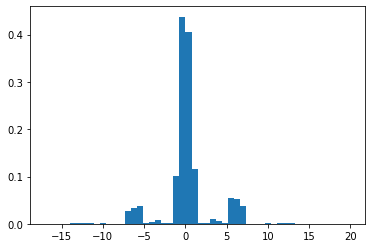

In [227]:
h=plt.hist(run_info[run_info["run_num"]<0].run_midpoint,density=True, bins=50)

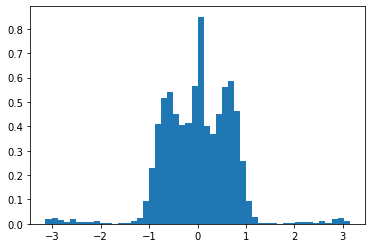

In [228]:
h=plt.hist(run_info[run_info["run_num"]<0].theta_midpoint,density=True, bins=50)

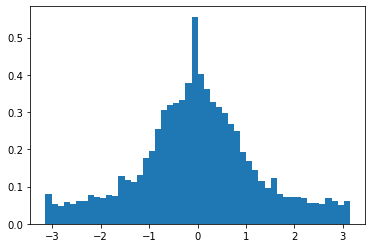

In [231]:
h=plt.hist((run_info[run_info["run_num"]>=0].run_midpoint + np.pi) % (2*np.pi)-np.pi,density=True, bins=50)

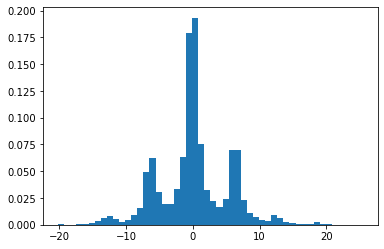

In [230]:
h=plt.hist(run_info[run_info["run_num"]>=0].run_midpoint,density=True, bins=50)

In [174]:
import seaborn as sns

In [175]:
run_info.columns


Index(['flyid_', 'run_num_', 'angle_first', 'angle_last',
       'last_food_index_first', 'run_midpoint'],
      dtype='object')

In [229]:
post_runs = run_info[run_info['run_num']>=0]

<AxesSubplot:xlabel='run_midpoint', ylabel='Count'>

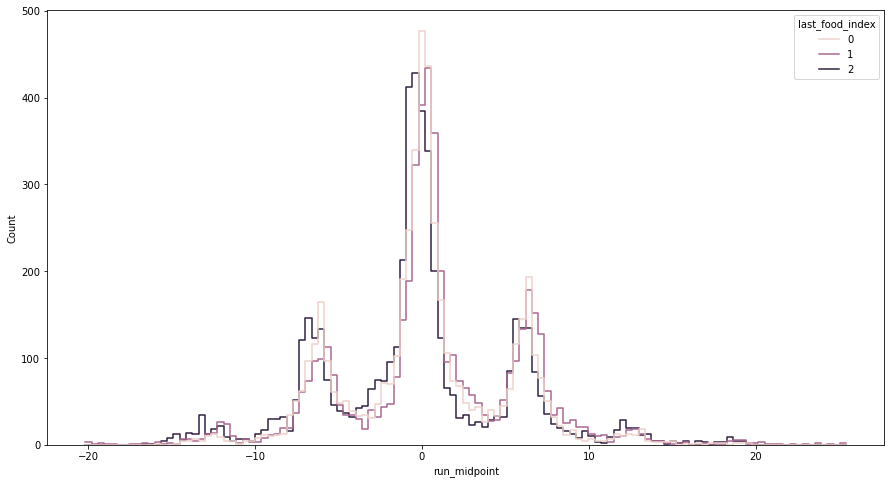

In [233]:
plt.figure(figsize=(15,8))
sns.histplot(data=post_runs, x='run_midpoint', hue='last_food_index', element='step', fill=False)
# plt.xlim(-np.pi, np.pi)

<AxesSubplot:xlabel='theta_midpoint', ylabel='Count'>

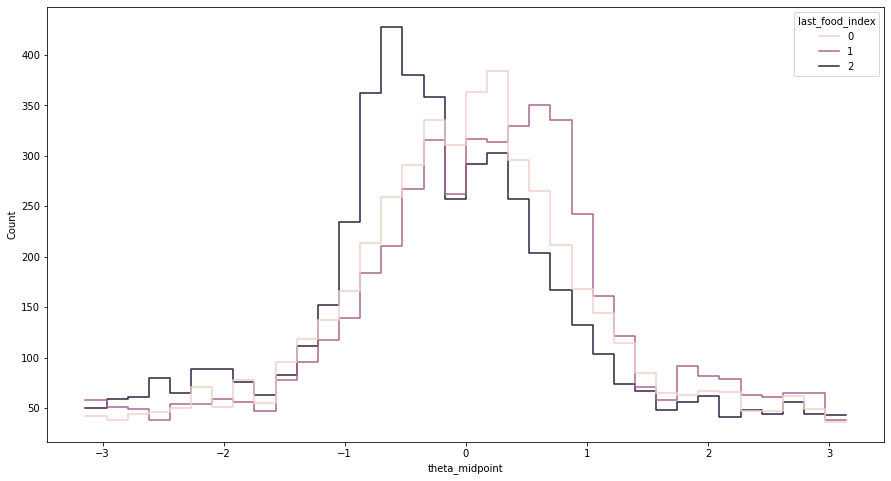

In [314]:
plt.figure(figsize=(15,8))
sns.histplot(data=post_runs, x='theta_midpoint', hue='last_food_index', element='step', fill=False, bins=36)
# plt.xlim(-np.pi, np.pi)

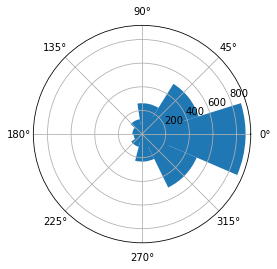

In [184]:
ax = plt.subplot(111, polar=True)
h=ax.hist(post_runs[post_runs.last_food_index_first==0].run_midpoint, bins=50)

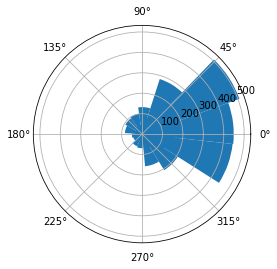

In [186]:
ax = plt.subplot(111, polar=True)
h=ax.hist(post_runs[post_runs.last_food_index_first==1].run_midpoint, bins=100)

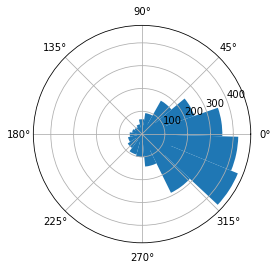

In [187]:
ax = plt.subplot(111, polar=True)
h=ax.hist(post_runs[post_runs.last_food_index_first==2].run_midpoint, bins=100)

In [192]:
# run_info.rename(columns={"run_num_": "run_num", "flyid_": "flyid","last_food_index_first":"last_food_index"}, inplace=True)

In [193]:
run_info.head()

,flyid,run_num,angle_first,angle_last,last_food_index,run_midpoint
0,0,-28.0,-0.966644,2.174949e+00,0,0.604152
1,0,-27.0,2.054118,1.208305e-01,0,1.087474
2,0,-26.0,0.241661,1.329135e+00,0,0.785398
3,0,-25.0,1.208305,-8.326673e-17,0,0.604152
4,0,-24.0,0.120830,1.329135e+00,0,0.724983


In [200]:
df.columns

Index(['t', 'angle', 'eating', 'direction', 'smelling', 'run_num', 'flyid',
       'last_food_coord', 'last_food_index'],
      dtype='object')

In [203]:
food_coords = df.last_food_coord.unique()

In [259]:
def angle_in_range(angle, angle_from, angle_to):
    afrom = angle_minuspitopi(angle_from)    
    ato = angle_minuspitopi(angle_to)
#     print(afrom, ato)
    a = angle_minuspitopi(angle)
    if ato >= afrom:
#         print("ato>afrom")
        return (a < ato) and (a > afrom)
    if ato < afrom:
#         print(f"ato<afrom; a={a}")
        a = angle_minuspitopi(a+np.pi)        
#         print(a)
#         print("a<afrom", a<afrom)
#         print("a>ato", a>ato)
        return (a<afrom) and (a > ato)

        

In [372]:
def angle_in_range2(angle, angle_from, angle_to):
    if abs(angle_to - angle_from)>=2*np.pi:
        return True
    afrom = angle_minuspitopi(angle_from)    
    ato = angle_minuspitopi(angle_to)    
    a = angle_minuspitopi(angle)
    reversing = ((ato-afrom)*(angle_to - angle_from) < 0)
#     print("reversing", reversing)
    if not reversing:
#         print(afrom, ato)
#         print(a-ato, a-afrom)
        return (a - ato) * (a - afrom) < 0
    if reversing:
#         print(a-ato, a-afrom)
        a = angle_minuspitopi(a+np.pi)        
#         print(a-ato, a-afrom)
        return (a - ato) * (a - afrom) < 0


In [361]:
angle_in_range(0, -np.pi/4, np.pi/4)

True

In [362]:
angle_in_range2(0, -np.pi/4, np.pi/4)

reversing False
-0.7853981633974483 0.7853981633974483
-0.7853981633974483 0.7853981633974483


True

In [363]:
angle_in_range(0, np.pi/4, np.pi/2)

False

In [364]:
angle_in_range(0, np.pi/4, np.pi/2)

False

In [365]:
angle_in_range(np.pi, np.pi/4, np.pi+7*np.pi/8)

True

In [366]:
angle_in_range2(np.pi, np.pi/4, np.pi+7*np.pi/8)

reversing True
-2.7488935718910685 -3.9269908169872414
0.3926990816987246 -0.7853981633974483


True

In [367]:
angle_in_range(np.pi/4, -np.pi/4, 0)

False

In [370]:
angle_in_range2(0, np.pi/4, -np.pi/4)

reversing False
0.7853981633974483 -0.7853981633974483
0.7853981633974483 -0.7853981633974483


True

In [371]:
angle_in_range(0, np.pi/4, -np.pi/4)

False

In [369]:
for ifood, food_coord in enumerate(food_coords):
    col = f"contains_{ifood}"
    run_info[col] = run_info.apply(lambda row: angle_in_range(food_coord, row.angle_first, row.angle_last), axis=1)

In [261]:
run_info.head()

,flyid,run_num,angle_first,angle_last,last_food_index,direction,run_midpoint,theta_midpoint,contains_0,contains_1,contains_2
0,0,-28.0,-0.966644,2.174949e+00,0,1,0.604152,0.604152,True,True,True
1,0,-27.0,2.054118,1.208305e-01,0,-1,1.087474,1.087474,False,False,False
2,0,-26.0,0.241661,1.329135e+00,0,1,0.785398,0.785398,False,True,False
3,0,-25.0,1.208305,-8.326673e-17,0,-1,0.604152,0.604152,False,False,False
4,0,-24.0,0.120830,1.329135e+00,0,1,0.724983,0.724983,False,True,False


In [269]:
run_info["contains_food"] = run_info.contains_0.astype(int) + run_info.contains_1.astype(int) + run_info.contains_2.astype(int)

In [270]:
run_info.contains_food.value_counts()

0    21555
1     8418
3     4372
2     4302
Name: contains_food, dtype: int64

In [278]:
ap_runs = run_info[run_info.run_num<0]

In [272]:
ap_runs.shape

(23691, 12)

In [325]:
last_two_runs = ap_runs[ap_runs.run_num>=-3]

In [303]:
last_two_runs.head(10)

,flyid,run_num,angle_first,angle_last,last_food_index,direction,run_midpoint,theta_midpoint,contains_0,contains_1,contains_2,contains_food
26,0,-2.0,-5.920694,-5.074880,0,1,-5.497787,0.785398,False,True,False,1
27,0,-1.0,-5.195711,-8.337304,0,-1,-6.766507,-0.483322,False,False,False,0
67,1,-2.0,0.362491,-2.295779,1,-1,-0.966644,-0.966644,False,False,False,0
68,1,-1.0,-2.174949,1.329135,1,1,-0.422907,-0.422907,True,True,True,3
112,2,-2.0,-0.845813,0.362491,2,1,-0.241661,-0.241661,True,False,True,2
113,2,-1.0,0.241661,-0.724983,2,-1,-0.241661,-0.241661,False,False,False,0
157,10,-2.0,-6.162355,-5.074880,0,1,-5.618618,0.664568,False,True,False,1
158,10,-1.0,-5.195711,-6.645677,0,-1,-5.920694,0.362491,False,False,False,0
200,11,-2.0,6.041524,6.283185,1,1,6.162355,-0.120830,True,False,False,1
201,11,-1.0,6.162355,0.241661,1,-1,3.202008,-3.081177,True,False,False,1


In [304]:
last_two_runs.groupby("run_num").contains_food.value_counts()

run_num  contains_food
-2.0     0                493
         1                216
         2                114
         3                 77
-1.0     0                471
         3                214
         2                134
         1                 81
Name: contains_food, dtype: int64

In [315]:
good_ones3 = ap_runs[(ap_runs.run_num==-3) & (ap_runs.contains_food==3)]

In [317]:
flies3=good_ones3.flyid.unique()

In [320]:
flies3

array([  51,   61,  120,  121,  131,  390,  492,  540,  562,  581,  792,
        860, 1020, 1031, 1061, 1112, 1400, 1422, 1461, 1491, 1621, 1641,
       1651, 1671, 1672, 1930, 1961, 2011, 2041, 2160, 2371, 2392, 2500,
       2660, 2752, 2840])

In [318]:
flies2=good_ones.flyid.unique()

In [323]:
set(flies2).intersection({1,22,345})

{22}

In [319]:
set(flies3).intersection(set(flies2))

set()

In [293]:
good_ones = ap_runs[(ap_runs.run_num==-2) & (ap_runs.contains_food==3)]

In [294]:
good_ones

,flyid,run_num,angle_first,angle_last,last_food_index,direction,run_midpoint,theta_midpoint,contains_0,contains_1,contains_2,contains_food
366,22,-2.0,-0.724983,1.570796,2,1,0.422907,0.422907,True,True,True,3
679,50,-2.0,-0.966644,1.812457,0,1,0.422907,0.422907,True,True,True,3
759,52,-2.0,-1.329135,1.449966,2,1,0.060415,0.060415,True,True,True,3
1060,80,-2.0,5.316541,7.128999,0,1,6.222770,-0.060415,True,True,True,3
1282,92,-2.0,-1.570796,1.449966,2,1,-0.060415,-0.060415,True,True,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...
34389,2662,-2.0,-1.449966,1.208305,2,1,-0.120830,-0.120830,True,True,True,3
35048,2712,-2.0,-1.570796,2.295779,2,1,0.362491,0.362491,True,True,True,3
36448,2822,-2.0,5.316541,7.370660,2,1,6.343601,0.060415,True,True,True,3
36820,2852,-2.0,-0.966644,0.724983,2,1,-0.120830,-0.120830,True,True,True,3


In [295]:
good_ones.last_food_index.value_counts()

2    38
0    25
1    14
Name: last_food_index, dtype: int64

In [296]:
good_flies = good_ones.flyid

In [297]:
good_flies

366        22
679        50
759        52
1060       80
1282       92
         ... 
34389    2662
35048    2712
36448    2822
36820    2852
38632    2992
Name: flyid, Length: 77, dtype: int64

In [298]:
example_flyids = good_ones.groupby("last_food_index").flyid.first()

In [299]:
example_flyids

last_food_index
0     50
1    171
2     22
Name: flyid, dtype: int64

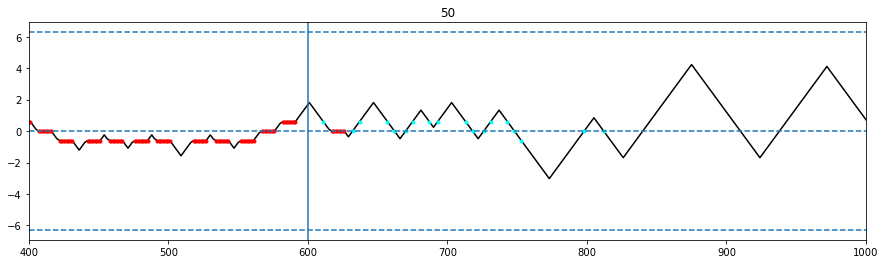

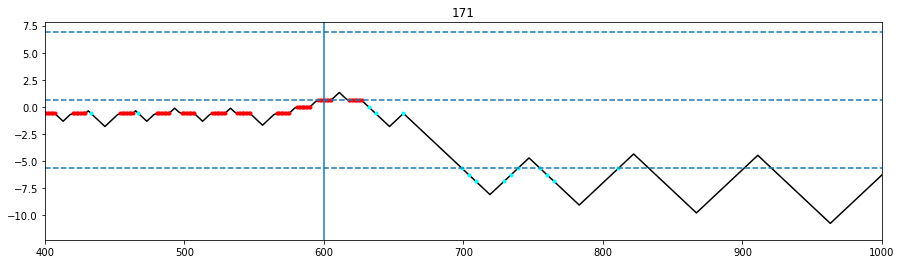

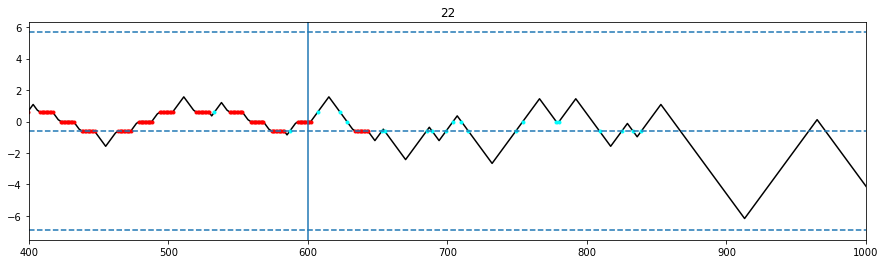

In [301]:
for fly in example_flyids:
    data = df[df.flyid==fly]
    plt.figure(figsize=(15,4))
    plt.plot(data.t, data.angle, color='k')
    plt.plot(data[data.eating].t, data[data.eating].angle, '.', color='red')
    plt.plot(data[data.smelling].t,data[data.smelling].angle , '.', color='cyan')
    plt.axhline(data.last_food_coord.iloc[0], ls='--')
    plt.axhline(data.last_food_coord.iloc[0]+2*np.pi, ls='--')
    plt.axhline(data.last_food_coord.iloc[0]-2*np.pi, ls='--')
    plt.axvline(600)
    plt.xlim(400,1000)    
    plt.title(str(fly))

In [326]:
ap_runs[(ap_runs.flyid==22)&(ap_runs.run_num>=-3)]

,flyid,run_num,angle_first,angle_last,last_food_index,direction,run_midpoint,theta_midpoint,contains_0,contains_1,contains_2,contains_food
365,22,-3.0,1.087474,-0.845813,2,-1,0.120830,0.120830,False,False,False,0
366,22,-2.0,-0.724983,1.570796,2,1,0.422907,0.422907,True,True,True,3
367,22,-1.0,1.449966,-1.208305,2,-1,0.120830,0.120830,False,False,False,0


In [327]:
a1 = 1.087474
a2 = -0.845813
a=0


In [328]:
angle_in_range?

In [329]:
angle_in_range(a, a1, a2)

False

<AxesSubplot:xlabel='theta_midpoint', ylabel='Density'>

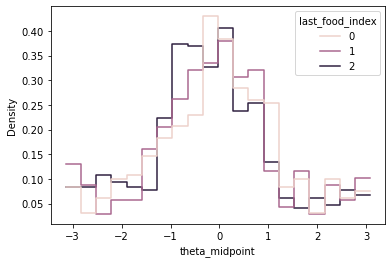

In [311]:
# plt.figure(figsize=(15,8))
sns.histplot(data=post_runs[post_runs.flyid.isin(good_flies)], x='theta_midpoint', hue='last_food_index', 
             element='step', fill=False, stat='density', common_norm=False, bins=20)
# plt.xlim(-np.pi, np.pi)